# Домашнее задание 1. Исследование сходимости методов безусловной оптимизации на примере логистической регрессии

## Описание задания

В этом задании предлагается сравнить скорость работы и сходимость изученных методов безусловной оптимизации для задачи многоклассовой логистической регрессии на простых данных - [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist).

Датасет содержит 60000 примеров, каждый из которых представляет собой вытянутую в вектор картинку 28х28. Каждая картинка принадлежит одному из 10 классов. Задача - определить, к какому классу принадлежит картинка.

Один из самых широко используемых методов решения такой задачи -- логистическая регрессия. В ней для предсказания вероятностей классов $p_i; i=1,\dots,K$ по набору входных данных $X \in \mathbb{R}^{N \times m}$ используется линейная функция от входа и функция softmax для преобразования ее выходов в вероятности:

$$z = W^T X + b; \ \ \ \ p_i = \frac{exp(-z_i)}{\sum_{k=1}^K exp(-z_k)} - \text{вероятность объекта принадлежать классу }i$$

Для поиска подходящей матрицы $W$ и вектора $b$ минимизируется функция потерь (категориальная кросс-энтропия) между предсказанием модели и правильными ответами. На одном примере категориальная кросс-энтропия записывается как

$$L = \sum\limits_{k=1}^K y_k \ln{p_k}$$

Чтобы избежать "переобучения" логистической регрессии (чрезмерной подстройки под обучающие данные), в функцию потерь добавляют L2-регуляризацию - слагаемое, "штрафующее" слишком большие значения в матрице $W$ и векторе $b$:

$$L = \sum\limits_{k=1}^K y_k \ln{p_k} + C(||W||^2 + ||b||^2)$$

На всем датасете категориальная кросс-энтропия вычисляется как среднее значение кросс-энтропии среди всех примеров датасета.

## Задача 1 (2 балла). Реализовать вычисление функции потерь логистической регрессии и ее градиента

Используйте матричные вычисления numpy, не используйте в реализации функций циклы for, while и т.д. Решение с использованием циклов будет оценено не более чем в 1 балл. К тому же решение на матрицах numpy будет работать гораздо быстрее, чем на циклах.

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [138]:
def L(X, Y, W, b, C=1):
    """
    X: (N, M) is the input data
    Y: (N, K) is one-hot encoded classes; in each row, only one y_i=1; the rest are zeros
    W: (M, K) is the logistic regression matrix
    b: (K, 1) is the logistic regression bias vector, s.t. Y_i ~ W^T X_i + b
    C: scalar is the regularization coef
    """
    z = X @ W + b.T
    z -= np.max(z, axis=1, keepdims=True)
    prob = z - np.log(np.sum(np.exp(z), axis=1, keepdims=True))
    loss = -np.sum(Y * prob) / X.shape[0] + C * (np.linalg.norm(W) ** 2 + np.linalg.norm(b) ** 2)
    return loss

def dL(X, Y, W, b, C):
    """
    X: (N, M) is the input data
    Y: (N, K) is one-hot encoded classes; in each row, only one y_i=1; the rest are zeros
    W: (M, K) is the logistic regression matrix
    b: (K, 1) is the logistic regression bias vector, s.t. Y_i ~ W^T X_i + b
    C: scalar is the regularization coef
    """
    z = X @ W + b.T
    z -= np.max(z, axis=1, keepdims=True)
    p = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    dLdW = X.T @ (p - Y) / X.shape[0] + 2 * C * W
    dLdb = np.sum((p - Y), axis = 0) / X.shape[0] + 2 * C * b
    return dLdW, dLdb

## Задача 2 (5 баллов). Исследовать сходимость логистической регрессии методами первого порядка

Для начала загрузим датасет

In [139]:
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data', kind='train')
X_test, y_test = mnist_reader.load_mnist('data', kind='t10k')

In [140]:
def onehot(y):
    result = np.zeros((y.shape[0], 10))
    result[np.arange(y.shape[0]), y] = 1
    return result

In [141]:
y_train = onehot(y_train)
y_test = onehot(y_test)

In [142]:
X_train.shape

(60000, 784)

Датасет содержит 60000 объектов, мы для ускорения сходимости будем оптимизировать функцию потерь только на первой тысяче примеров. Каждый объект представляется вектором размерности 784, и кодируется одним из 10 классов. Таким образом, в логистической регрессии оптимизируется функция $L(W, b)$ от $784 \cdot 10+10=7850$ переменных. Поэтому методы нулевого порядка, перебирающие координаты, и требующие $O(n)$ вычислений функции L (где n - кол-во переменных), не будем даже пытаться использовать. Для оптимизации будем использовать различные методы первого и второго порядка.

In [143]:
X_train = X_train[:1000]
y_train = y_train[:1000]

In [144]:
from tqdm import tqdm
import time

### 2.1. (2 балла)

Реализуйте алгоритм градиентного спуска и прогоните его с постоянным шагом (размер шага уменьшается, если текущий шаг вдоль антиградиента увеличивает значение функции). В ходе спуска запоминайте время выполнения каждой итерации в секундах - оно будет нужно для последующего построения графиков.

Также реализуйте и прогоните алгоритм градиентного спуска с выбором шага по правилу Армихо. Проверьте адекватность спуска с помощью вычисления точности предсказания класса (accuracy). Она должна быть не менее 0.97. Если немного не достигает 0.97 - попробуйте градиентный спуск с меньшим значением eps.

Постройте два сравнительных графика сходимости градиентного спуска с постоянным шагом и с шагом по правилу Армихо. На одном графике отложите на оси x - число итераций, на оси y - значение функции L в логарифмическом масштабе. На втором графике на оси x вместо числа итераций отложите время в секундах, прошедшее от старта спуска. Подпишите графики, оси графиков и данные на них - за отсутствие графиков или подписей на них оценка будет уменьшена на 1 балл.

In [145]:
def compute_step_size(loss_new, loss_old, step_size, min_step=1e-6):
    if loss_new > loss_old:
        step_size = max(step_size / 2 , min_step)
    return step_size

def armijo_step_size(W, b, dLdW, dLdb, X, Y, step_size, C=1, beta=0.8, c=1e-6):
    L_old = L(X, Y, W, b, C)
    while True:
        W_new = W - step_size * dLdW
        b_new = b - step_size * dLdb
        
        
        L_new = L(X, Y, W_new, b_new, C)
        
        if L_new <= L_old - c * step_size * (np.linalg.norm(dLdW)**2 + np.linalg.norm(dLdb)**2):
            break  
        
        step_size *= beta  
        
    return step_size  


In [146]:
def accuracy(W, b):
    n_correct = 0
    N = X_train.shape[0]
    for i in range(N):
        prediction = X_train[i:i + 1] @ W + b
        #print(prediction.shape, y_train[i].shape)
        if np.argmax(prediction) == np.argmax(y_train[i]):
            n_correct += 1
    return n_correct / N

In [147]:

def gradient_descent(X, Y, 
                     W_start, b_start, 
                     compute_step_size_par = compute_step_size,
                     C=1, max_iter=10000, eps1=1e-3, eps2=1e-5):
    """
    X: (N, M) is the input data
    Y: (N, K) is one-hot encoded classes; in each row, only one y_i=1; the rest are zeros
    W_start: (M, K) is the initial logistic regression matrix
    b_start: (K, 1) is the initial logistic regression bias vector, s.t. Y_i ~ W^T X_i + b
    compute_step_size: function which takes W, b, and gradients, and selects the best step size in the anti-gradient direction
    C: regularization coefficient
    max_iter: the maximum number of descent iterations
    tolerance: if the gradient norm is less than this value, then we stop the descent
    """
    d = X.shape[1]
    k = Y.shape[1]
    N = X.shape[0]
    W = np.ones((d, k)) / (d * k)
    b = np.ones(k) / k
    L_history, time_history = [], []
    step_size = 0.0001
    loss_old = L(X, Y, W, b)
    loss_new = L(X, Y, W, b)
    min_step = 1e-6
    start = time.time()
    for i in tqdm(range(max_iter)):
        dLdW, dLdb = dL(X, Y, W, b, C)
        if compute_step_size_par == armijo_step_size:
            step_size = armijo_step_size(W, b, dLdW, dLdb, X, Y, step_size)
            W -= step_size * dLdW 
            b -= step_size * dLdb
            
        else:
            loss_old = loss_new
            loss_new =  L(X, Y, W, b)
            step_size = compute_step_size(loss_old, loss_new, step_size)
            if step_size > min_step:  
                step_size = step_size
            else:
                step_size = min_step
            W -= step_size *dLdW
            b -= step_size * dLdb
        if np.linalg.norm(dLdW) < eps1 or np.linalg.norm(dLdb) < eps2:
            break

        time_history.append(time.time() - start)
           
        L_history.append(L(X, Y, W, b, C))
        


        
    
    return W, b, L_history, time_history


100%|██████████| 10000/10000 [01:25<00:00, 116.74it/s]


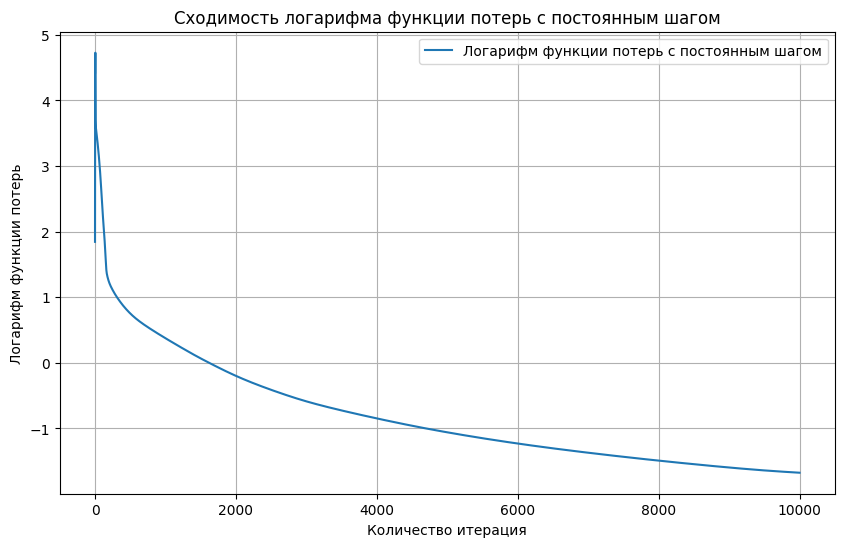

In [148]:
import matplotlib.pyplot as plt
W_start = np.random.randn(X_train.shape[1], y_train.shape[1]) * 0.001  
b_start = np.zeros(y_train.shape[1])  

W_opt_1, b_opt_1, L_history_1, time_history_1 = gradient_descent(X_train, y_train, W_start, b_start)

plt.figure(figsize=(10, 6))
plt.plot(np.log(L_history_1), label='Логарифм функции потерь с постоянным шагом')
plt.xlabel('Количество итерация')
plt.ylabel('Логарифм функции потерь')
plt.title('Сходимость логарифма функции потерь с постоянным шагом')
plt.legend()
plt.grid(True)
plt.show()


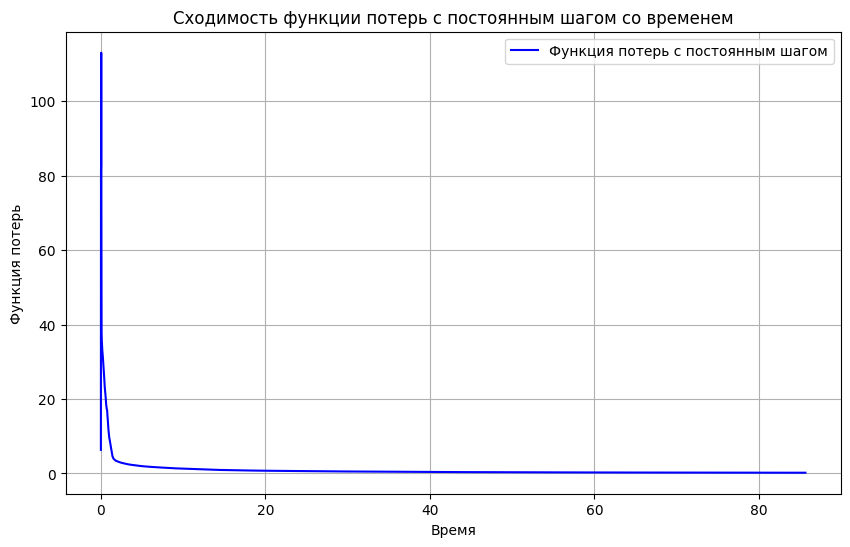

In [152]:

plt.figure(figsize=(10, 6))
plt.plot(time_history_1, L_history_1, label='Функция потерь с постоянным шагом', color='blue')
plt.xlabel('Время')
plt.ylabel('Функция потерь')
plt.title('Сходимость функции потерь с постоянным шагом со временем')
plt.legend()
plt.grid(True)
plt.show()

In [156]:
print('Accuracy для алгоритма с постоянным шагом', accuracy(W_opt_1, b_opt_1))

Accuracy для алгоритма с постоянным шагом 0.993


100%|██████████| 10000/10000 [01:41<00:00, 98.47it/s]


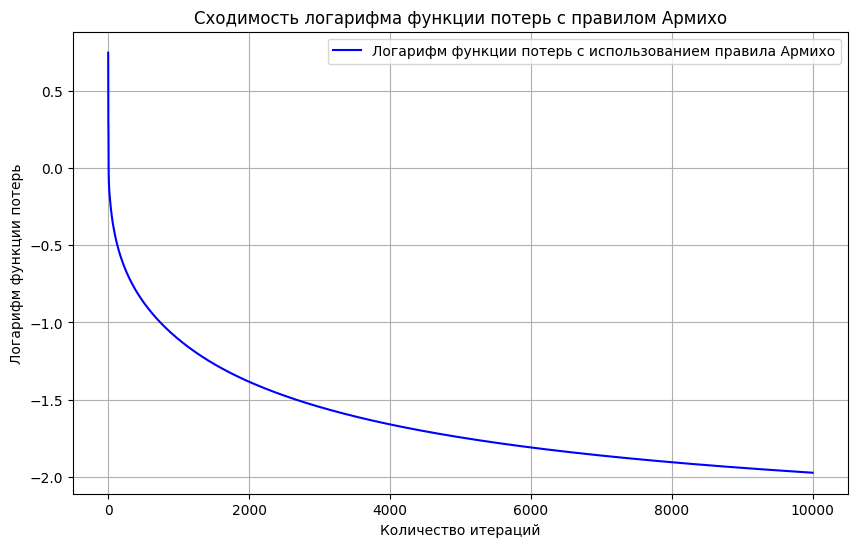

In [153]:
import matplotlib.pyplot as plt
W_start = np.random.randn(X_train.shape[1], y_train.shape[1]) * 0.001  
b_start = np.zeros(y_train.shape[1])  

W_opt_2, b_opt_2, L_history_2, time_history_2 = gradient_descent(X_train, y_train, W_start, b_start,  compute_step_size_par = armijo_step_size)

plt.figure(figsize=(10, 6))
plt.plot(np.log(L_history_2), label='Логарифм функции потерь с использованием правила Армихо', color='blue')
plt.xlabel('Количество итераций')
plt.ylabel('Логарифм функции потерь')
plt.title('Сходимость логарифма функции потерь с правилом Армихо')
plt.legend()
plt.grid(True)
plt.show()


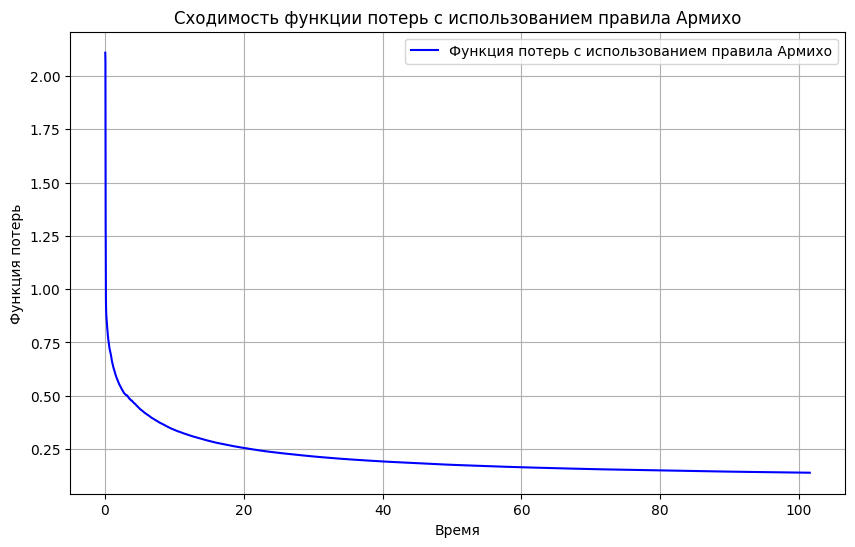

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(time_history_2, L_history_2, label='Функция потерь с использованием правила Армихо', color='blue')
plt.xlabel('Время')
plt.ylabel('Функция потерь')
plt.title('Сходимость функции потерь с использованием правила Армихо')
plt.legend()
plt.grid(True)
plt.show()


In [155]:
print('Accuracy для алгоритма с правилом Армихо', accuracy(W_opt_2, b_opt_2))

Accuracy для алгоритма с правилом Армихо 1.0


### 2.2. (3 балла)

Реализуйте метод Флетчера-Ривса и также прогоните его до сходимости с теми же параметрами. Также проверьте адекватность решения с помощью подсчета accuracy (должна быть не менее 0.97).

Выбор шага в методе Флетчера-Ривса реализуйте методом наискорейшего спуска (путем решения вторичной задачи минимизации $\phi(\alpha) = f(x_k + \alpha * d_k) \rightarrow \min$ с помощью метода золотого сечения). Использование готовых библиотечных функций типа `scipy.optimize.minimize` для задачи вторичной оптимизации запрещено - решение с ним будет оценено не более чем в 1 балл.

Постройте на одном листе с графиками сравнения из пункта 2.1. график сходимости метода Флетчера-Ривса, и также замерьте время сходимости. Сделайте выводы о скорости сходимости методов.

In [158]:
def golden_section_search(f, a, b, tol=1e-5):
    phi = (3 - np.sqrt(5)) / 2
    c = b - phi * (b - a)
    d = a + phi * (b - a)
    fc = f(c)
    fd = f(d)
    while abs(b - a) > tol:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - phi * (b - a)
            fc = f(c)
        else:
            a, c, fc = c, d, fd
            d = a + phi * (b - a)
            fd = f(d)
    return (a + b) / 2

def compute_step_size_f(X, Y, W, b, dW, db, C):
    func = lambda alpha: L(X, Y, W + alpha * dW, b + alpha * db, C)
    return golden_section_search(func, 0, 0.000000001)

In [159]:
def fletcher_reeves(X, Y, C=1, compute_step_size_f=compute_step_size_f, max_iter=10000, eps1=1e-3, eps2=1e-5):
    """
    X: (N, M) is the input data
    Y: (N, K) is one-hot encoded classes; in each row, only one y_i=1; the rest are zeros
    W_start: (M, K) is the initial logistic regression matrix
    b_start: (K, 1) is the initial logistic regression bias vector, s.t. Y_i ~ W^T X_i + b
    compute_step_size: function which takes W, b, dW, and db, and selects the best step size in direction (dW, db)
    max_iter: the maximum number of descent iterations
    tolerance: if the gradient norm is less than this value, then we stop the descent
    """
    d = X.shape[1]
    k = Y.shape[1]
    N = X.shape[0]
    W = np.ones((d, k)) / (d * k)
    b = np.ones((k)) / k
    grad_W, grad_b = dL(X, Y, W, b, C=1)
    dLdW, dLdb = -grad_W, -grad_b
    L_history, time_history = [], []
    start = time.time()
        
    for i in tqdm(range(max_iter)):
        # your code here
        alpha = compute_step_size_f(X, Y, W, b, dLdW, dLdb, C)
        W_new, b_new = W + alpha * dLdW, b + alpha * dLdb
        grad_W_new, grad_b_new = dL(X, Y, W_new, b_new, C)
        beta = np.sum(grad_W_new**2 + grad_b_new**2) / max(1e-8, np.sum(grad_W**2 + grad_b**2))
        dLdW, dLdb = -grad_W_new + beta * dLdW, -grad_b_new + beta * dLdb
        W, b = W_new, b_new
        grad_W, grad_b = grad_W_new, grad_b_new
        
        if np.linalg.norm(grad_W) < eps1 or np.linalg.norm(grad_b) < eps2:
            break
        time_history.append(time.time() - start)

        L_history.append(L(X, Y, W, b))

    return W, b, L_history, time_history

In [160]:
import matplotlib.pyplot as plt
W_start = np.random.randn(X_train.shape[1], y_train.shape[1]) * 0.001  
b_start = np.zeros(y_train.shape[1])  

W_opt_gold, b_opt_gold, L_history_gold, time_history_gold = fletcher_reeves(X_train, y_train)

100%|██████████| 10000/10000 [02:00<00:00, 82.66it/s]


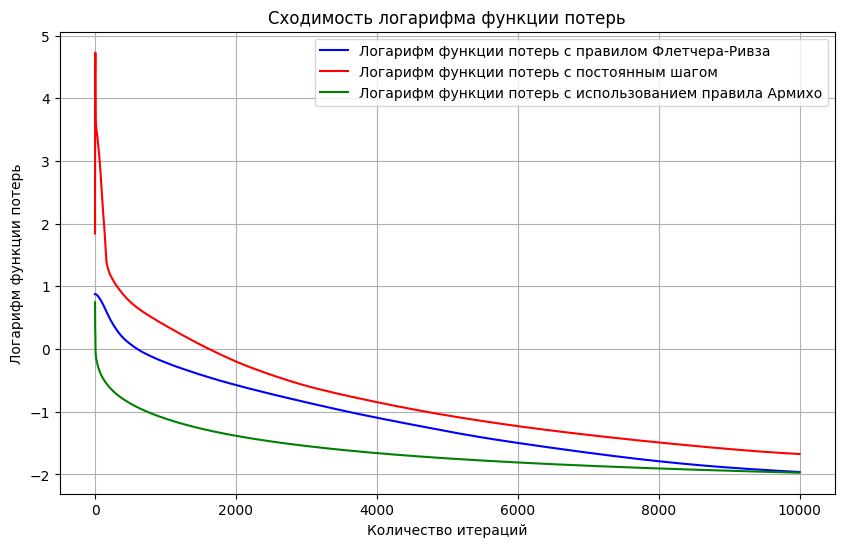

In [161]:
plt.figure(figsize=(10, 6))
plt.plot(np.log(L_history_gold), label='Логарифм функции потерь с правилом Флетчера-Ривза', color='blue')
plt.plot(np.log(L_history_1), label='Логарифм функции потерь с постоянным шагом', color = 'red')
plt.plot(np.log(L_history_2), label='Логарифм функции потерь с использованием правила Армихо', color='green')
plt.xlabel('Количество итераций')
plt.ylabel('Логарифм функции потерь')
plt.title('Сходимость логарифма функции потерь')
plt.legend()
plt.grid(True)
plt.show()

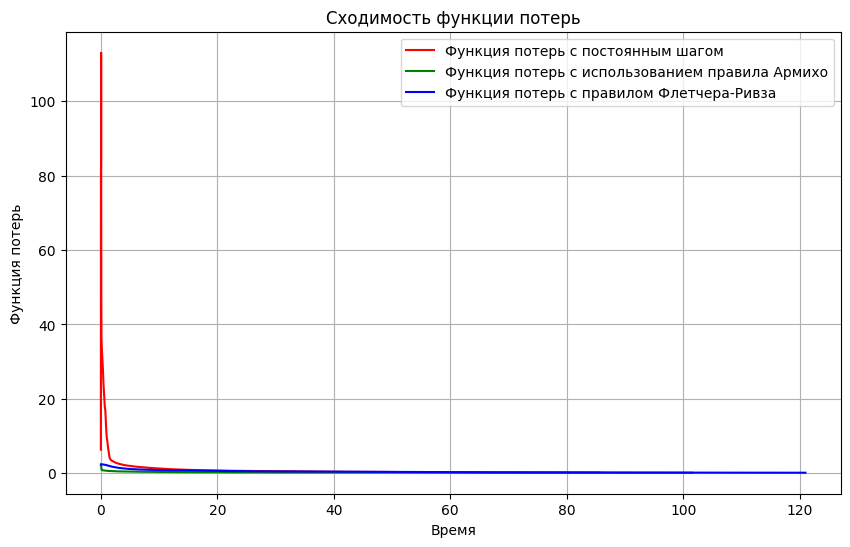

In [162]:

plt.figure(figsize=(10, 6))
plt.plot(time_history_1, L_history_1, label='Функция потерь с постоянным шагом', color='red')
plt.plot(time_history_2, L_history_2, label='Функция потерь с использованием правила Армихо', color='green')
plt.plot(time_history_gold, L_history_gold, label='Функция потерь с правилом Флетчера-Ривза', color='blue')

plt.xlabel('Время')
plt.ylabel('Функция потерь')
plt.title('Сходимость функции потерь')
plt.legend()
plt.grid(True)
plt.show()

In [163]:
print('Время сходимости градиента с постоянным шагом:', time_history_1[-1])
print('Время сходимости градиента с шагом по правилу Армихо:', time_history_2[-1])
print('Время сходимости метода Флетчера Ривса:', time_history_gold[-1])

Время сходимости градиента с постоянным шагом: 85.66228795051575
Время сходимости градиента с шагом по правилу Армихо: 101.54575276374817
Время сходимости метода Флетчера Ривса: 120.98844003677368


Самая быстрая сходимость у градиентного спуска с постоянным шагом. Это связано с тем, что он не тратит дополнительное время на подбор шага на каждой итерации. Градиентный спуск с шагом по правилу Армихо работает медленнее, чем метод с постоянным шагом, так как на каждой итерации требуется выполнить дополнительные вычисления для подбора шага, удовлетворяющего условию Армихо. Метод Флетчера-Ривса оказался самым медленным.

## Задача 3 (3 балла). Исследовать сходимость логистической регрессии квазиньютоноскими методами

Применение метода Ньютона "в лоб" требует на каждом шаге вычисления матрицы Гессе размером 7850х7850 - это примерно $6 \times 10^7$ операций по каждому из 1000 объектов, т.е. порядка $10^{11}$ вычислений (несколько минут на стандартном ЦПУ). Чтобы избавиться от столь большого объема вычислений, есть два пути:

1. Считать матрицу Гессе не по всем объектам, а по какому-то случайно выбранному подмножеству (тут мы забегаем вперед, в стохастическую оптимизацию). И все равно у нас остается долгая операция - обращение матрицы Гессе. Вместо обращения "в лоб" можно решать систему уравнений $H(x_k) d_k = -\nabla f(x_k)$ методом сопряженных градиентов. Это сложно и выходит за рамки первого ДЗ.

2. Приближать матрицу Гессе матрицами первого порядка - например, как в алгоритме BFGS.

В этом пункте реализуйте алгоритм BFGS и прогоните на датасете до сходимости с теми же критериями остановки, что и в задаче 2. Шаг можно выбирать так: начать с какого-то большого значения, например, 1. Далее - уменьшать его в 2 раза, пока шаг не приведет к уменьшению функции. Также шаг можно выбирать методом наискорейшего спуска (как в методе Флетчера-Ривса). Для решения задачи вторичной оптимизации также используйте метод золотого сечения - использование готовых библиотечных функций также запрещено.

Прогоните алгоритм BFGS с обоими вариантами выбора шага. Постройте графики сходимости, сравните его с графиком сходимости методов из задачи 2.

При вычислении приближенной обратной матрицы Гессе постройте вычисления так, чтобы итоговая сложность была $O(n^2)$, а не $O(n^3)$.

In [118]:
def golden_section_search(f, a, b, tol=1e-4):
    phi = (3 - np.sqrt(5)) / 2
    c = b - phi * (b - a)
    d = a + phi * (b - a)
    fc = f(c)
    fd = f(d)
    while abs(b - a) > tol:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - phi * (b - a)
            fc = f(c)
        else:
            a, c, fc = c, d, fd
            d = a + phi * (b - a)
            fd = f(d)
    return (a + b) / 2

def compute_step_size_last(X, Y, W, b, dW, db, C):
    func = lambda alpha: L(X, Y, W + alpha * dW, b + alpha * db, C)
    return golden_section_search(func, 0, 1e-3)

import numpy as np
from tqdm import tqdm

In [119]:
def bfgs(X, Y, C=1, compute_step_size=compute_step_size_last, max_iter=10000, eps1=1e-2, eps2=1e-4):
    d = X.shape[1]
    k = Y.shape[1]
    N = X.shape[0]
    W = np.ones((d, k)) / (d * k)
    b = np.ones((k)) / k
    
    hess_inv_approx = np.eye(d * k + k)
    grad_W, grad_b = dL(X, Y, W, b, C=1)
    grad = np.concatenate([grad_W.flatten(), grad_b])
    theta = np.concatenate([W.flatten(), b])
    L_history, time_history = [], []
    for i in tqdm(range(max_iter)):
        start = time.time()
        direction = -hess_inv_approx @ grad
        # your code here
        t = compute_step_size_last(X, Y, W, b, grad_W, grad_b, C=1)
        delta = t * direction
        delta_W, delta_b = delta[:d * k].reshape(d, k), delta[d * k:]
        W_new, b_new = W + delta_W, b + delta_b
        grad_W_new, grad_b_new = dL(X, Y, W_new, b_new, C)
        grad_new = np.concatenate([grad_W_new.flatten(), grad_b_new])
        if np.linalg.norm(grad_new) < eps1 or np.linalg.norm(delta) < eps2:
            break
        y_k = grad_new - grad
        s_k = delta
        rho_k = 1 / (y_k @ s_k)
        I = np.eye(len(grad))

        if rho_k > 0:
            V = I - rho_k * np.outer(s_k, y_k)
            hess_inv_approx = V @ hess_inv_approx @ V.T + rho_k * np.outer(s_k, s_k)
        
        W, b, grad_W, grad_b, grad = W_new, b_new, grad_W_new, grad_b_new, grad_new
        time_history.append(time.time() - start)
        L_history.append(L(X, Y, W, b))

    return W, b, L_history, time_history

In [120]:
from tqdm import tqdm

In [121]:
import matplotlib.pyplot as plt 

W_opt_last, b_opt_last, L_history_last, time_history_last = bfgs(X_train, y_train,max_iter=1000)

100%|██████████| 1000/1000 [4:41:43<00:00, 16.90s/it]  


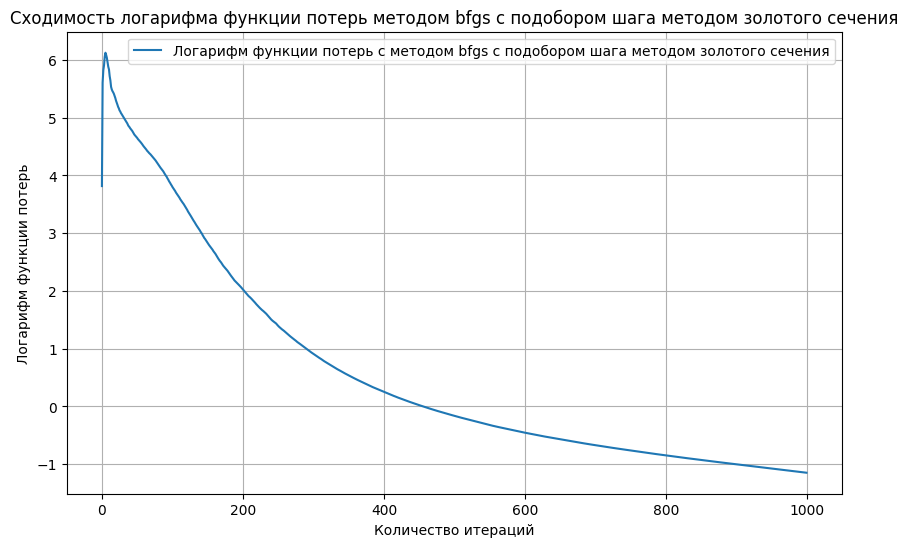

In [126]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))
plt.plot(np.log(L_history_last), label='Логарифм функции потерь с методом bfgs с подобором шага методом золотого сечения')
plt.xlabel('Количество итераций')
plt.ylabel('Логарифм функции потерь')
plt.title('Сходимость логарифма функции потерь методом bfgs с подобором шага методом золотого сечения')
plt.legend()
plt.grid(True)
plt.show()

In [129]:
print('Accuracy для градиента функции потерь с методом bfgs с подбором шага методом золотого сечения', accuracy(W_opt_last, b_opt_last))

Accuracy для градиента функции потерь с методом bfgs с подбором шага методом золотого сечения 1.0


In [36]:
def const_step(loss_func):
    const = 1
    while loss_func(const) > loss_func(0):
        const /= 2
    return const

In [37]:
def bfgs(X, Y, C=1, compute_step_size=compute_step_size_simple, max_iter=10000, eps1=1e-3, eps2=1e-5):
    d = X.shape[1]
    k = Y.shape[1]
    N = X.shape[0]
    W = np.ones((d, k)) / (d * k)
    b = np.ones((k)) / k
    
    hess_inv_approx = np.eye(d * k + k)
    grad_W, grad_b = dL(X, Y, W, b, C=1)
    grad = np.concatenate([grad_W.flatten(), grad_b])
    theta = np.concatenate([W.flatten(), b])
    L_history, time_history = [], []
    for i in tqdm(range(max_iter)):
        direction = -hess_inv_approx @ grad
        # your code here
        def loss_func(alpha):
            new_theta = theta + alpha * direction
            W_new = new_theta[:d * k].reshape(d, k)
            b_new = new_theta[d * k:]
            return L(X, Y, W_new, b_new, C)
        t = const_step(loss_func)
        delta = t * direction
        delta_W, delta_b = delta[:d * k].reshape(d, k), delta[d * k:]
        W_new, b_new = W + delta_W, b + delta_b
        grad_W_new, grad_b_new = dL(X, Y, W_new, b_new, C)
        grad_new = np.concatenate([grad_W_new.flatten(), grad_b_new])
        if np.linalg.norm(grad_new) < eps1 or np.linalg.norm(delta) < eps2:
            break

        y_k = grad_new - grad
        s_k = delta
        rho_k = 1 / (y_k @ s_k)
        I = np.eye(len(grad))

        if rho_k > 0:
            V = I - rho_k * np.outer(s_k, y_k)
            hess_inv_approx = V @ hess_inv_approx @ V.T + rho_k * np.outer(s_k, s_k)
        
        W, b, grad_W, grad_b, grad = W_new, b_new, grad_W_new, grad_b_new, grad_new
        L_history.append(L(X, Y, W, b))

    return W, b, L_history, time_history

In [40]:
W_opt_easy, b_opt_easy, L_history_easy, time_history_easy = bfgs(X_train, y_train,max_iter=1000)

 46%|████▌     | 462/1000 [2:44:44<3:11:50, 21.40s/it]


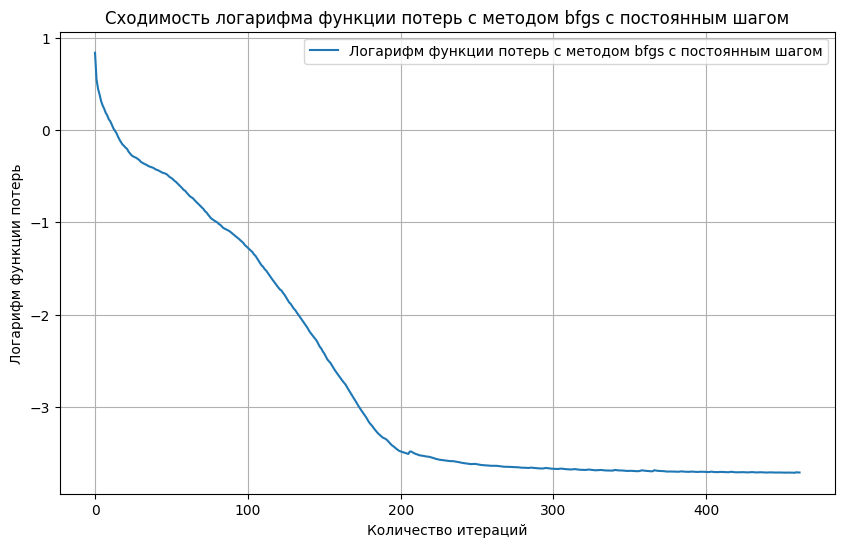

In [127]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))
plt.plot(np.log(L_history_easy), label='Логарифм функции потерь с методом bfgs с постоянным шагом')
plt.xlabel('Количество итераций')
plt.ylabel('Логарифм функции потерь')
plt.title('Сходимость логарифма функции потерь с методом bfgs с постоянным шагом')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
print('Accuracy для градиента функции потерь с методом bfgs с постоянным шагом', accuracy(W_opt_easy, b_opt_easy))

Accuracy для градиента функции потерь с методом bfgs с постоянным шагом 1.0


Теперь подведем итог, сравнив все опробованные выше методы:

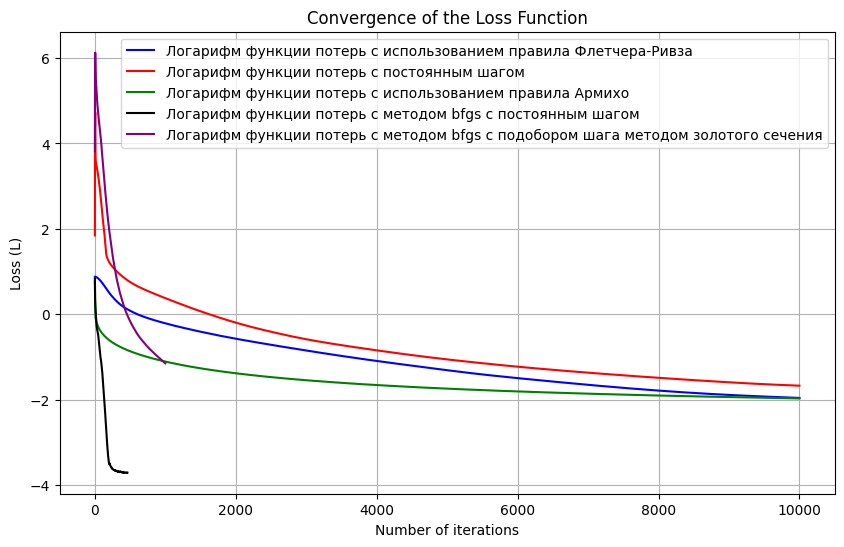

In [164]:
plt.figure(figsize=(10, 6))
plt.plot(np.log(L_history_gold), label='Логарифм функции потерь с использованием правила Флетчера-Ривза', color='blue')
plt.plot(np.log(L_history_1), label='Логарифм функции потерь с постоянным шагом', color='red')
plt.plot(np.log(L_history_2), label='Логарифм функции потерь с использованием правила Армихо', color='green')
plt.plot(np.log(L_history_easy), label='Логарифм функции потерь с методом bfgs с постоянным шагом', color = 'black')
plt.plot(np.log(L_history_last), label='Логарифм функции потерь с методом bfgs с подобором шага методом золотого сечения', color = 'purple')
plt.xlabel('Number of iterations')
plt.ylabel('Loss (L)')
plt.title('Convergence of the Loss Function')
plt.legend()
plt.grid(True)
plt.show()

Видно, что наиболее эффективным оказался метод bfgs. Хотя он в сочетании с методом золотого сечения остановился не в лучшем локальном минимуме, я связываю это с неудачным подбором гиперпараметров для метода золотого сечения, так как с постоянным шагом bfgs показывает очень эффективный результат